source of this function: https://github.com/OdysseasKr/neural-disaggregator <br>
metrics for GRU code: https://github.com/OdysseasKr/neural-disaggregator/blob/master/GRU/metrics.py  <br>

Nilmtk electric function which gives the input to metrics.py <br> 
source: https://github.com/nilmtk/nilmtk/blob/master/nilmtk/electric.py 


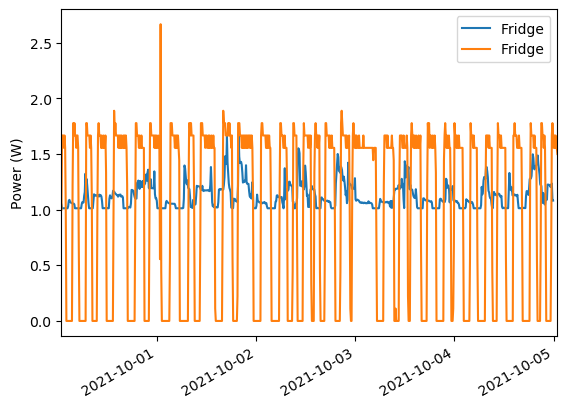

In [1]:
from nilmtk import DataSet 

test = DataSet(r'\Users\micki\nilmtk_test\data\converted_v14.h5')
test_elec = test.buildings[1].elec

result = DataSet('disag-outSEL_v05.h5')
res_elec = result.buildings[1].elec
predicted = res_elec['fridge']
ground_truth = test_elec['fridge']

import matplotlib.pyplot as plt
predicted.plot()
ground_truth.plot()
#plt.savefig('GRU_fridge', dpi='figure')
plt.show()


In [3]:
# predicted.plot()
# ground_truth.plot()

# plt.xlim('2021-10-01','2021-10-03')

helpful in navigating datasets in NILMTK: https://github.com/nilmtk/nilmtk/blob/master/docs/manual/user_guide/loading_data_into_memory.ipynb 

In [6]:
# fridge = res_elec['fridge']
# fridge.available_columns()

[('power', 'active')]

In [8]:
# df = next(fridge.load())
# df
# #these are results of disaggregated fridge

In [9]:
# # changing sampling frequency of predicted fridge
# # https://stackoverflow.com/questions/25055712/pandas-every-nth-row 
# # Dataframe.resample() works only with timeseries data. - alllegedly 
# df3 = df.iloc[::60,:]
# df3

In [10]:
# import matplotlib.pyplot as plt
# #df3.iloc[:,0]
# df3['power'].plot()
# plt.show()

NameError: name 'df3' is not defined

In [11]:
# df1 = next(true_fridge.load())
# df1
# #these are results of the ground truth data of fridge, collected by the smart plugg 

In [12]:
# scikit library from which I can take my metrics: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html 
#  R^2 (coefficient of determination) regression score function.

from sklearn.metrics import r2_score 

#acc = r2_score(list(df1['power']['active']), list(df3['power']['active']))

r2 = r2_score(df1.iloc[:7141], df3)
r2

-0.03905168984490093

In [13]:
from sklearn.metrics import accuracy_score

acc = accuracy_score(df1.iloc[:7141], df3)
acc

ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [14]:
x = df3['power']['active']


In [15]:

def rms_error_power(predictions, ground_truth):
    '''Compute RMS error in assigned power
    
    .. math::
            error^{(n)} = \\sqrt{ \\frac{1}{T} \\sum_t{ \\left ( y_t - \\hat{y}_t \\right )^2 } }
    Parameters
    ----------
    predictions, ground_truth : nilmtk.MeterGroup
    Returns
    -------
    error : pd.Series
        Each index is an meter instance int (or tuple for MeterGroups).
        Each value is the RMS error in predicted power for that appliance.
    '''

    error = {}

    both_sets_of_meters = iterate_through_submeters_of_two_metergroups(
        predictions, ground_truth)
    for pred_meter, ground_truth_meter in both_sets_of_meters:
        sum_of_squared_diff = 0.0
        n_samples = 0
        for aligned_meters_chunk in align_two_meters(pred_meter, 
                                                     ground_truth_meter):
            diff = aligned_meters_chunk.iloc[:, 0] - aligned_meters_chunk.iloc[:, 1]
            diff.dropna(inplace=True)
            sum_of_squared_diff += (diff ** 2).sum()
            n_samples += len(diff)

        error[pred_meter.instance()] = math.sqrt(sum_of_squared_diff / n_samples)

    return pd.Series(error)



In [16]:
# from nilmtk.metrics import rms_error_power 
# rms_error_power(predicted, ground_truth)

from sklearn.metrics import mean_squared_error
mean_squared_error(df1.iloc[:7141],df3)

0.82318175

In [17]:
test_elec

MeterGroup(meters=
  ElecMeter(instance=1, building=1, dataset='SEL', site_meter, appliances=[])
  ElecMeter(instance=2, building=1, dataset='SEL', appliances=[Appliance(type='fridge', instance=1)])
  ElecMeter(instance=3, building=1, dataset='SEL', appliances=[Appliance(type='electric oven', instance=1)])
  ElecMeter(instance=4, building=1, dataset='SEL', appliances=[Appliance(type='kettle', instance=1)])
  ElecMeter(instance=5, building=1, dataset='SEL', appliances=[Appliance(type='stove', instance=1)])
)

In [18]:
import metrics
rpaf = metrics.recall_precision_accuracy_f1(predicted, ground_truth)
print("============ Recall: {}".format(rpaf[0]))
print("============ Precision: {}".format(rpaf[1]))
print("============ Accuracy: {}".format(rpaf[2]))
print("============ F1 Score: {}".format(rpaf[3]))

print("============ Relative error in total energy: {}".format(metrics.relative_error_total_energy(predicted, ground_truth)))
print("============ Mean absolute error(in Watts): {}".format(metrics.mean_absolute_error(predicted, ground_truth)))

C:\Users\micki\nilmtk_test\GRU\metrics.py:77: RuntimeWarning: invalid value encountered in true_divide
  return tp/float(tp+fp)


============ Recall: 0.0
============ Precision: nan
============ Accuracy: 0.016664293500715452
============ F1 Score: nan
============ Relative error in total energy: 0.9852609804462142
============ Mean absolute error(in Watts): 1.1041636090695233
